In [1]:
%pylab inline
import glob
import re

Populating the interactive namespace from numpy and matplotlib


In [2]:
def read_ws_results(file):
    
    results = open(file, 'rt').read().split("\n")
    results = [line for line in results if 'Result' in line]
    
    results = [(re.findall('\w+.txt', line)[0], float(line.split()[-1])) for line in results]
    
    return results

def read_tfl_result(file):
    
    results = open(file, 'rt').read().split("\n")
    results = [line for line in results if 'Result' in line]
    
    results = [('toefl', float(line.split()[-1])) for line in results]
    
    return results

def read_syn_sem_results(file):
    
    results = open(file, 'rt').read().split("\n")
    results = [results[i:i+3] for i in range(0, len(results), 3)][:-1]
    
    results = [(f'syn-sem_{res[0].rstrip(":")}', 
                *map(float, re.findall("\d+\.\d+", res[-1])),
               re.findall("\(.+\)", res[1])[0][1:-1] ) for res in results]
    results = [(res[0], res[1]/100, res[-1]) for res in results]
    
    return results

def read_metrics(results_folders):
    
    results_dict = {
    'ws353':[],
    'ws353_relatedness':[],
    'ws353_similarity':[],
    'toefl':[],
    'syn-sem_family':[],
    'syn-sem_gram1-adjective-to-adverb':[],
    'syn-sem_gram2-opposite':[],
    'syn-sem_gram3-comparative':[],
    'syn-sem_gram4-superlative':[],
    'syn-sem_gram5-present-participle':[],
    'syn-sem_gram7-past-tense':[],
    'syn-sem_gram8-plural':[],
    'syn-sem_gram9-plural-verbs':[]
    }
    
    
    results_folders = files = sorted(results_folders, key=lambda item: int(re.findall("(?<=epoch-)\d+", item)[0]) )
    
    for res_fold in results_folders:
        
        ws_results = read_ws_results(res_fold+'/ws_test.txt')
    
        tfl_results = read_tfl_result(res_fold+'/toefl_test.txt')

        syn_sem_results = read_syn_sem_results(res_fold+'/syn-sem_test.txt')
        syn_sem_results = [(s[0], s[1]) for s in syn_sem_results]
        
        results = ws_results+tfl_results+syn_sem_results
    
        for key, val in results:
            if key.rstrip('.txt') in results_dict.keys():
                results_dict[key.rstrip('.txt')].append(val)

    return results_dict


def read_weat_results(file):
    
    results = open(file).read()
    results = results.split("--- ")
    results = [r for r in results if r!='' and 'Test not performed' not in r]
    results = [(r.split("\n")[0], *map(float, re.findall("(?:-)?\d+\.\d+", r.split("\n")[-2]))) for r in results]
    
    return results

In [3]:
show_also_inflected = False

In [4]:
test_names_lemmas = ['ws353_similarity', 'ws353_relatedness', 'ws353', 'syn-sem_gram2-opposite',
                    'syn-sem_family']
test_names_inflected = ['toefl', 
                        'syn-sem_gram9-plural-verbs', 'syn-sem_gram8-plural', 'syn-sem_gram7-past-tense', 
                        'syn-sem_gram5-present-participle', 'syn-sem_gram4-superlative', 'syn-sem_gram3-comparative',
                        'syn-sem_gram2-opposite', 'syn-sem_gram1-adjective-to-adverb', 'syn-sem_family']

In [5]:
dim = 300
windows = [3, 5, 7]
n_epochss = [20, 40]
alphas = ['default']

### Female corpus

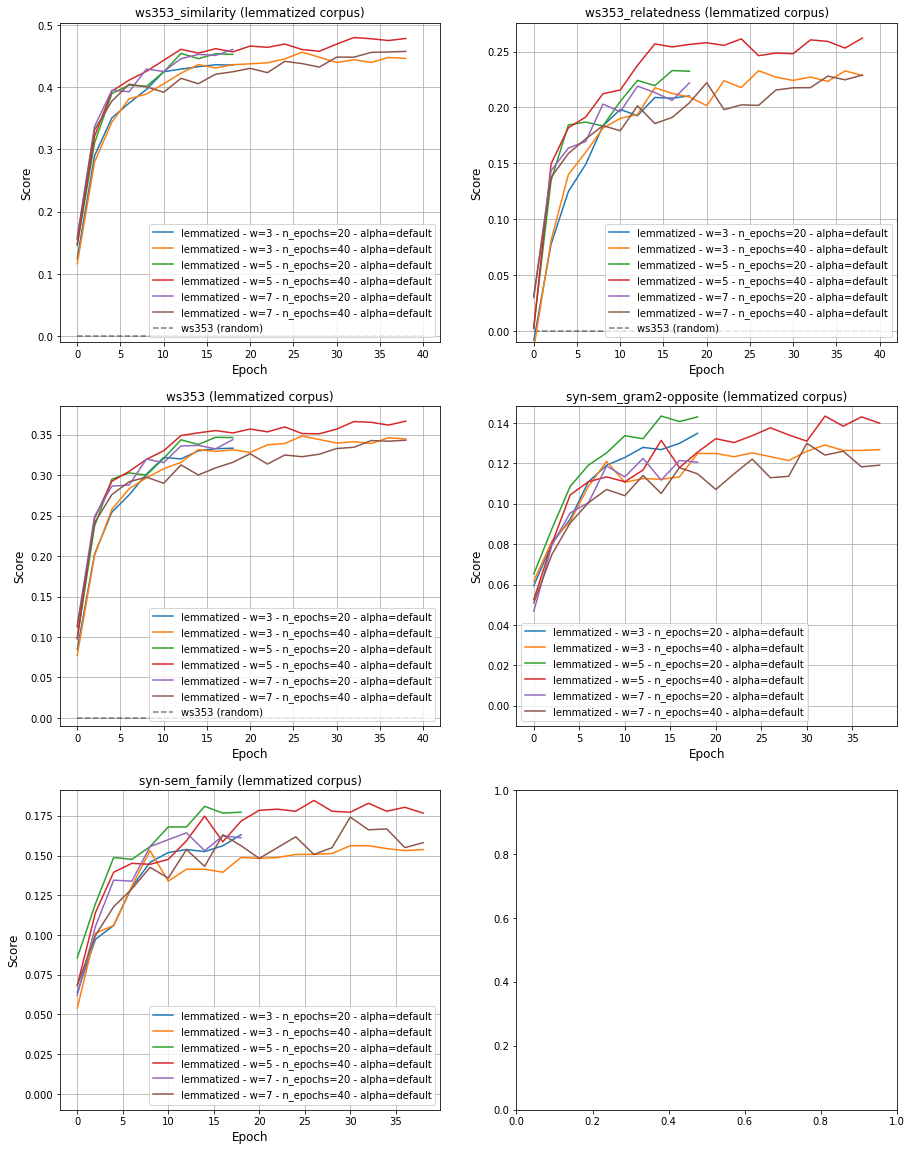

In [6]:
# one plot for each test

gender = 'female'

if show_also_inflected:
    n_tests = len(test_names_lemmas)+len(test_names_inflected)
    n_cols = 2
    n_rows = n_tests // n_cols + n_tests % n_cols
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15,35))
    
else:
    n_tests = len(test_names_lemmas)
    n_cols = 2
    n_rows = n_tests // n_cols + n_tests % n_cols
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15,20))
    



axs_test_dict = {}
results_folder = "../results/Word_embedding_quality_W2V/"
for corpus_type in ['', '_lemmatized']:
    if not show_also_inflected and corpus_type=='':
        continue
    for w in windows:
        for n_epochs in n_epochss:
            for alpha in alphas:
            
                emb_name = f"W2V{corpus_type}_dim-{dim}_w-{w}_alpha-{alpha}_epochs-{n_epochs}_corpus-{gender}_person_artist_lyrics_epoch-*/"
                res_files = glob.glob(results_folder+emb_name)
                
                results_dict = read_metrics(res_files) 
                
                # plot lemmas scores
                if corpus_type=='_lemmatized':
                    for n_, test_lemma in enumerate(test_names_lemmas, 0):
                        x_, y_ = n_//n_cols , n_%n_cols
                        if test_lemma in test_names_inflected:
                            axs_test_dict[test_lemma+'_'] = (x_, y_)
                        else:
                            axs_test_dict[test_lemma] = (x_, y_)

                        label = f'{corpus_type.lstrip("_")} - w={w} - n_epochs={n_epochs} - alpha={alpha}'
                        xrange = range(0, n_epochs, 2)
                        axs[x_, y_].plot(xrange, results_dict[test_lemma], label=label)
                        #axs[x_, y_].legend()
                        
                        
                n_ = len(test_names_lemmas)+1
                if corpus_type=='':
                    for n_, test_inflect in enumerate(test_names_inflected, n_):
                        x_, y_ = n_//n_cols , n_%n_cols
                        axs_test_dict[test_inflect] = (x_, y_)

                        label = f'{corpus_type} - w={w} - n_epochs={n_epochs} - alpha={alpha}'
                        xrange = range(0, n_epochs, 2)
                        axs[x_, y_].plot(results_dict[test_inflect], label=label)
                        #axs[x_, y_].legend()
                                 
                        
for test_name, axs_coord in axs_test_dict.items():
    x_, y_ = axs_coord
    if 'ws' in test_name:
        axs[x_, y_].hlines(0., 0, max(n_epochss), 
                   color='k', linestyles='dashed', alpha=0.5, label='ws353 (random)')
        
    if 'toefl' in test_name:
        axs[x_, y_].hlines(0.25, 0, max(n_epochss), color='k', 
                   linestyles='dashed', alpha=0.5, label='toefl (random)')
        
    
    if (test_name in test_names_lemmas or test_name.endswith("_")) and test_name!='syn-sem_gram2-opposite':
        axs[x_, y_].set_title(test_name.rstrip("_") + ' (lemmatized corpus)')
    elif test_name in test_names_inflected:
        axs[x_, y_].set_title(test_name + ' (inflected corpus)')
    axs[x_, y_].grid(visible=True)
    axs[x_, y_].legend()
    axs[x_, y_].set_xlabel("Epoch", fontsize=12)
    axs[x_, y_].set_ylabel("Score", fontsize=12)
    axs[x_, y_].set_ylim(bottom=-0.01)
     
            

In [7]:
for w in windows:
    for n_epochs in n_epochss:
        for alpha in alphas:

            emb_name = f"W2V{'_lemmatized'}_dim-{dim}_w-{w}_alpha-{alpha}_epochs-{n_epochs}_corpus-{gender}_person_artist_lyrics_epoch-*/"
            res_files = glob.glob(results_folder+emb_name)

            results_dict = read_metrics(res_files)['syn-sem_family']
            
            print(w, n_epochs)
            print(results_dict[-1])
            print()
            

3 20
0.1631

3 40
0.15380000000000002

5 20
0.1773

5 40
0.17670000000000002

7 20
0.1612

7 40
0.15810000000000002



### Male corpus

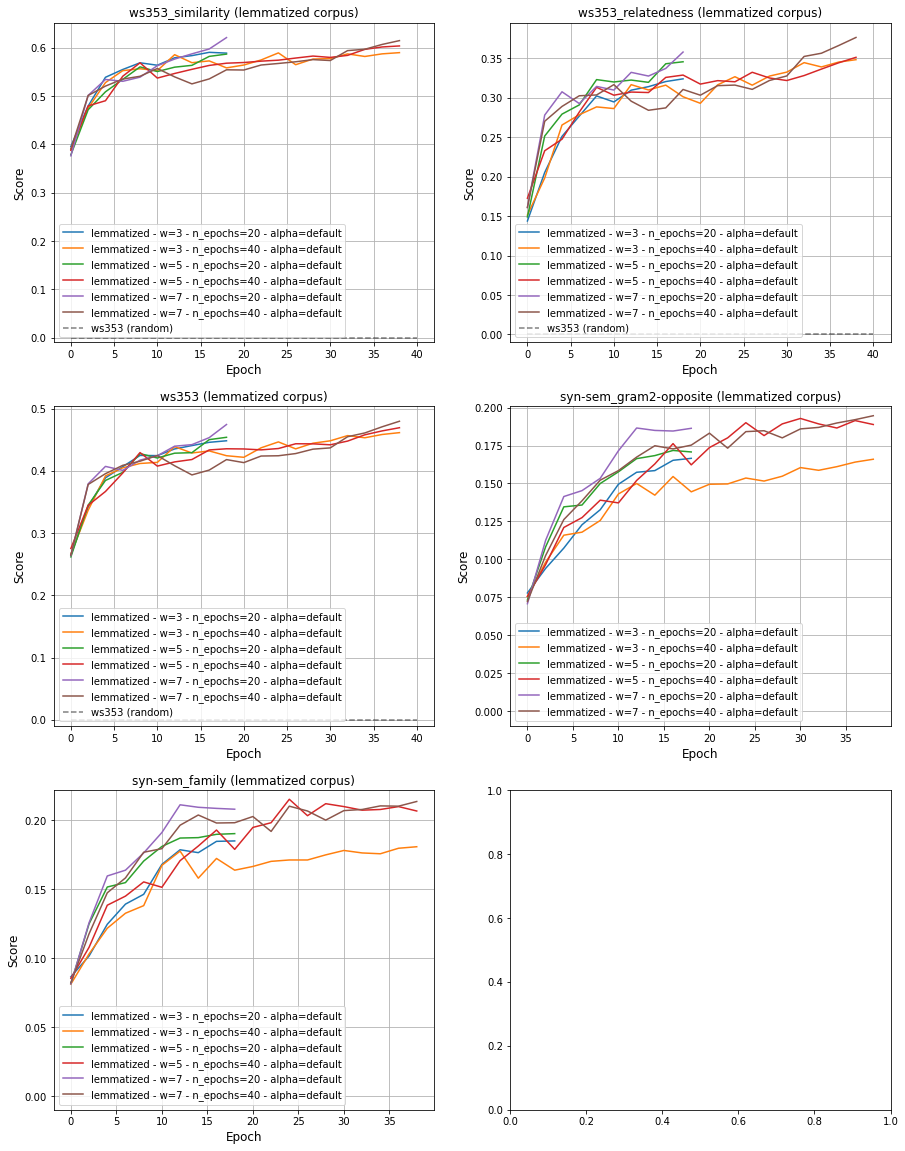

In [8]:
# one plot for each test

gender = 'male'

if show_also_inflected:
    n_tests = len(test_names_lemmas)+len(test_names_inflected)
    n_cols = 2
    n_rows = n_tests // n_cols + n_tests % n_cols
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15,35))
    
else:
    n_tests = len(test_names_lemmas)
    n_cols = 2
    n_rows = n_tests // n_cols + n_tests % n_cols
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15,20))

axs_test_dict = {}
results_folder = "../results/Word_embedding_quality_W2V/"
for corpus_type in ['', '_lemmatized']:
    if not show_also_inflected and corpus_type=='':
        continue
    for w in windows:
        for n_epochs in n_epochss:
            for alpha in alphas:
            
                emb_name = f"W2V{corpus_type}_dim-{dim}_w-{w}_alpha-{alpha}_epochs-{n_epochs}_corpus-{gender}_person_artist_lyrics_epoch-*/"
                res_files = glob.glob(results_folder+emb_name)
                
                results_dict = read_metrics(res_files) 
                

                # plot lemmas scores
                if corpus_type=='_lemmatized':
                    for n_, test_lemma in enumerate(test_names_lemmas, 0):
                        x_, y_ = n_//n_cols , n_%n_cols
                        if test_lemma in test_names_inflected:
                            axs_test_dict[test_lemma+'_'] = (x_, y_)
                        else:
                            axs_test_dict[test_lemma] = (x_, y_)

                        label = f'{corpus_type.lstrip("_")} - w={w} - n_epochs={n_epochs} - alpha={alpha}'
                        xrange = range(0, n_epochs, 2)
                        if len(xrange)!=len(results_dict[test_lemma]): continue
                        axs[x_, y_].plot(xrange, results_dict[test_lemma], label=label)
                        #axs[x_, y_].legend()
                        
                        
                n_ = len(test_names_lemmas) + 1
                if corpus_type=='':
                    for n_, test_inflect in enumerate(test_names_inflected, n_):
                        x_, y_ = n_//n_cols , n_%n_cols
                        axs_test_dict[test_inflect] = (x_, y_)

                        label = f'{corpus_type} - w={w} - n_epochs={n_epochs} - alpha={alpha}'
                        xrange = range(0, n_epochs, 2)
                        if len(xrange)!=len(results_dict[test_inflect]): continue
                        axs[x_, y_].plot(results_dict[test_inflect], label=label)
                        #axs[x_, y_].legend()
                        
    
              
for test_name, axs_coord in axs_test_dict.items():
    x_, y_ = axs_coord
    if 'ws' in test_name:
        axs[x_, y_].hlines(0., 0, max(n_epochss), 
                   color='k', linestyles='dashed', alpha=0.5, label='ws353 (random)')
        
    if 'toefl' in test_name:
        axs[x_, y_].hlines(0.25, 0, max(n_epochss), color='k', 
                   linestyles='dashed', alpha=0.5, label='toefl (random)')
        
    
    if (test_name in test_names_lemmas or test_name.endswith("_")) and test_name!='syn-sem_gram2-opposite':
        axs[x_, y_].set_title(test_name.rstrip("_") + ' (lemmatized corpus)')
    elif test_name in test_names_inflected:
        axs[x_, y_].set_title(test_name + ' (inflected corpus)')
    axs[x_, y_].grid(visible=True)
    axs[x_, y_].legend()
    axs[x_, y_].set_xlabel("Epoch", fontsize=12)
    axs[x_, y_].set_ylabel("Score", fontsize=12)
    axs[x_, y_].set_ylim(bottom=-0.01)
     
            

In [9]:
for w in windows:
    for n_epochs in n_epochss:
        for alpha in alphas:

            emb_name = f"W2V{'_lemmatized'}_dim-{dim}_w-{w}_alpha-{alpha}_epochs-{n_epochs}_corpus-{gender}_person_artist_lyrics_epoch-*/"
            res_files = glob.glob(results_folder+emb_name)

            results_dict = read_metrics(res_files)['syn-sem_family']
            
            print(w, n_epochs)
            print(results_dict[-1])
            print()
            

3 20
0.18489999999999998

3 40
0.1807

5 20
0.1902

5 40
0.2066

7 20
0.2079

7 40
0.21350000000000002



### All corpus

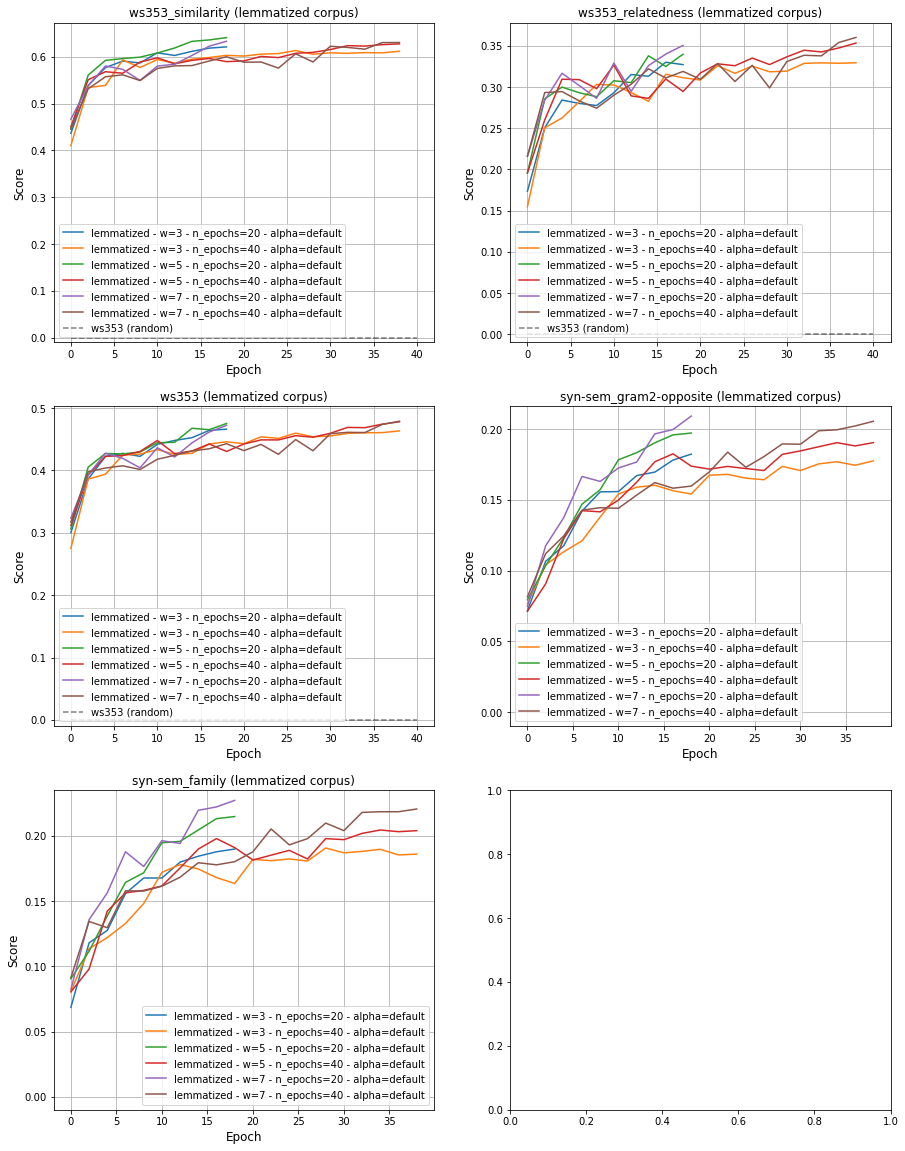

In [10]:
# one plot for each test

gender = 'all'

if show_also_inflected:
    n_tests = len(test_names_lemmas)+len(test_names_inflected)
    n_cols = 2
    n_rows = n_tests // n_cols + n_tests % n_cols
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15,35))
    
else:
    n_tests = len(test_names_lemmas)
    n_cols = 2
    n_rows = n_tests // n_cols + n_tests % n_cols
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15,20))


axs_test_dict = {}
results_folder = "../results/Word_embedding_quality_W2V/"
for corpus_type in ['', '_lemmatized']:
    if not show_also_inflected and corpus_type=='':
        continue
    for w in windows:
        for n_epochs in n_epochss:
            for alpha in alphas:
            
                emb_name = f"W2V{corpus_type}_dim-{dim}_w-{w}_alpha-{alpha}_epochs-{n_epochs}_corpus-{gender}_person_artist_lyrics_epoch-*/"
                res_files = glob.glob(results_folder+emb_name)
                
                results_dict = read_metrics(res_files) 
                
                
                # plot lemmas scores
                if corpus_type=='_lemmatized':
                    for n_, test_lemma in enumerate(test_names_lemmas, 0):
                        x_, y_ = n_//n_cols , n_%n_cols
                        if test_lemma in test_names_inflected:
                            axs_test_dict[test_lemma+'_'] = (x_, y_)
                        else:
                            axs_test_dict[test_lemma] = (x_, y_)

                        label = f'{corpus_type.lstrip("_")} - w={w} - n_epochs={n_epochs} - alpha={alpha}'
                        xrange = range(0, n_epochs, 2)
                        axs[x_, y_].plot(xrange, results_dict[test_lemma], label=label)
                        #axs[x_, y_].legend()
                        
                        
                n_ = len(test_names_lemmas)
                if corpus_type=='':
                    for n_, test_inflect in enumerate(test_names_inflected, n_):
                        x_, y_ = n_//n_cols , n_%n_cols
                        axs_test_dict[test_inflect] = (x_, y_)

                        label = f'{corpus_type} - w={w} - n_epochs={n_epochs} - alpha={alpha}'
                        xrange = range(0, n_epochs, 2)
                        axs[x_, y_].plot(results_dict[test_inflect], label=label)
                        #axs[x_, y_].legend()
                        
                
                
for test_name, axs_coord in axs_test_dict.items():
    x_, y_ = axs_coord
    if 'ws' in test_name:
        axs[x_, y_].hlines(0., 0, max(n_epochss), 
                   color='k', linestyles='dashed', alpha=0.5, label='ws353 (random)')
        
    if 'toefl' in test_name:
        axs[x_, y_].hlines(0.25, 0, max(n_epochss), color='k', 
                   linestyles='dashed', alpha=0.5, label='toefl (random)')
        
    
    if (test_name in test_names_lemmas or test_name.endswith("_")) and test_name!='syn-sem_gram2-opposite':
        axs[x_, y_].set_title(test_name.rstrip("_") + ' (lemmatized corpus)')
    elif test_name in test_names_inflected:
        axs[x_, y_].set_title(test_name + ' (inflected corpus)')
    axs[x_, y_].grid(visible=True)
    axs[x_, y_].legend()
    axs[x_, y_].set_xlabel("Epoch", fontsize=12)
    axs[x_, y_].set_ylabel("Score", fontsize=12)
    axs[x_, y_].set_ylim(bottom=-0.01)
     
            

In [11]:
for w in windows:
    for n_epochs in n_epochss:
        for alpha in alphas:

            emb_name = f"W2V{'_lemmatized'}_dim-{dim}_w-{w}_alpha-{alpha}_epochs-{n_epochs}_corpus-{gender}_person_artist_lyrics_epoch-*/"
            res_files = glob.glob(results_folder+emb_name)

            results_dict = read_metrics(res_files)['syn-sem_family']
            
            print(w, n_epochs)
            print(max(results_dict))
            print()
            

3 20
0.18989999999999999

3 40
0.1907

5 20
0.2148

5 40
0.2045

7 20
0.22719999999999999

7 40
0.2206

